Импорты

In [1]:
import math
import numpy as np
import pandas as pd
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from time import time 

import holidays
import prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_percentage_error


c:\repos\Kolesa-python-exam\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Импорт данных

In [2]:
# from google.oauth2 import service_account

# pd.set_option('display.max_columns', 599)
# pd.set_option('display.max_rows', 599)

# project_id = 'kolesa-android-app'
# credentials = 'C:/kolesa-android-app-715adc9bdf26.json'
# credentials = service_account.Credentials.from_service_account_file(credentials)

In [3]:
# q = """SELECT * FROM `kolesa-android-app.academy.time_series_dataset` ORDER BY 1"""

In [4]:
# data = pd.read_gbq(query=q, project_id=project_id, credentials=credentials, dialect='standard', progress_bar_type='tqdm') # Запрос данных из GBQ

Импорт если нет доступа к BG

In [5]:
#ЕСЛИ У ВАС НЕТ ДОСТУПА К BQ, ТО МОЖНО ЗАГРУЗИТЬ ДАННЫЕ ЧЕРЕЗ CSV

data = pd.read_csv('Data/data.csv')
data

,event_date,y
0,2022-01-19,15360
1,2022-11-08,19712
2,2021-06-07,12801
3,2021-03-28,12801
4,2021-04-15,13314
...,...,...
1091,2022-07-24,15103
1092,2022-02-28,15615
1093,2021-10-31,16383
1094,2021-12-01,16918


Подготовка данных

In [6]:
data.sort_values(by='event_date', inplace=True)
data

,event_date,y
376,2020-01-01,5721
345,2020-01-02,8274
532,2020-01-03,9344
574,2020-01-04,9864
843,2020-01-05,10435
...,...,...
623,2022-12-27,17042
285,2022-12-28,16195
495,2022-12-29,14966
56,2022-12-30,13070


In [7]:
data.dtypes

event_date    object
y              int64
dtype: object

In [8]:
data['event_date'] = pd.to_datetime(data['event_date'])
data.dtypes

event_date    datetime64[ns]
y                      int64
dtype: object

In [9]:
data.columns = ['ds', 'y']
data.index = pd.to_datetime(data['ds'])
data.head()

,ds,y
ds,,
2020-01-01,2020-01-01,5721
2020-01-02,2020-01-02,8274
2020-01-03,2020-01-03,9344
2020-01-04,2020-01-04,9864
2020-01-05,2020-01-05,10435


<Axes: xlabel='ds'>

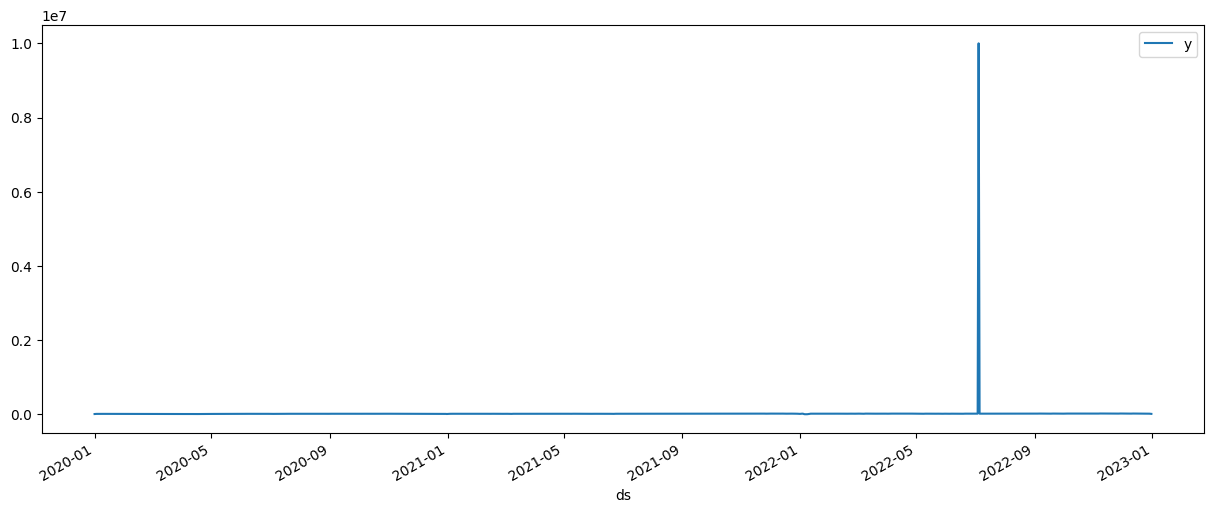

In [10]:
data.plot(x = 'ds', y = 'y', figsize=(15, 6))

In [11]:
data.idxmax()

ds   2022-12-31
y    2022-07-05
dtype: datetime64[ns]

In [12]:
for i in range(2):
    data.loc[data['y'].idxmax(), 'y'] = data['y'].mean()

C:\Users\lofas\AppData\Local\Temp\ipykernel_12744\1448882573.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '22644.69708029197' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['y'].idxmax(), 'y'] = data['y'].mean()


<Axes: xlabel='ds'>

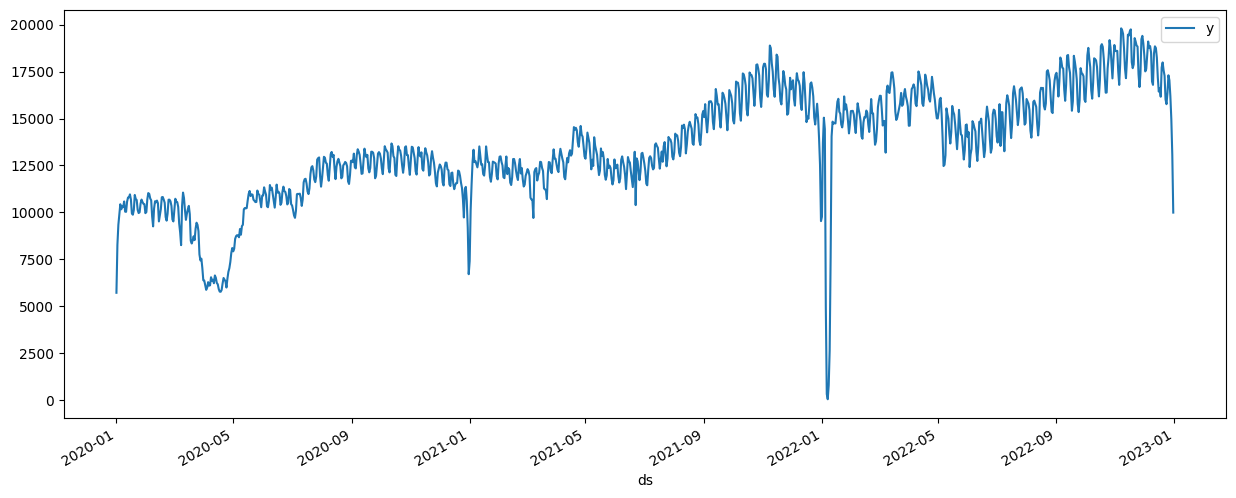

In [13]:
data.plot(x = 'ds', y = 'y', figsize=(15, 6))

In [14]:
for i in range(5):
    data.loc[data['y'].idxmin(), 'y'] = data['y'].mean()

<Axes: xlabel='ds'>

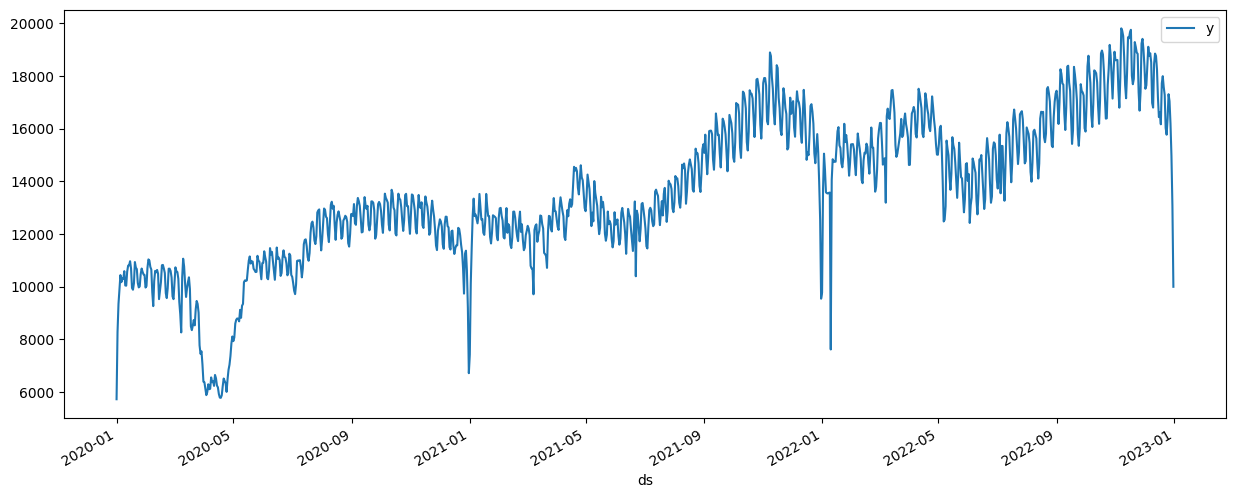

In [15]:
data.plot(x = 'ds', y = 'y', figsize=(15, 6))

Добавление Рамадана и Ковида

In [16]:
def is_ramadan(ds):
    date = pd.to_datetime(ds)
    return ((date >=pd.to_datetime('2020-04-24')) & (date <= pd.to_datetime('2020-05-24'))
            | (date >=pd.to_datetime('2021-04-13')) & (date <= pd.to_datetime('2021-05-13'))
            | (date >=pd.to_datetime('2022-04-03')) & (date <= pd.to_datetime('2022-05-03'))
            | (date >=pd.to_datetime('2023-03-23')) & (date <= pd.to_datetime('2023-04-23')))

data['is_ramadan'] = data['ds'].apply(is_ramadan)
data['ramadan'] = data['is_ramadan'].apply(int)

def is_covid(ds):
    date = pd.to_datetime(ds)
    return ((date >=pd.to_datetime('2020-03-16')) & (date <= pd.to_datetime('2020-06-01')))

data['is_covid'] = data['ds'].apply(is_covid)
data['covid'] = data['is_covid'].apply(int)
data.head()
    

,ds,y,is_ramadan,ramadan,is_covid,covid
ds,,,,,,
2020-01-01,2020-01-01,5721.0,False,0,False,0
2020-01-02,2020-01-02,8274.0,False,0,False,0
2020-01-03,2020-01-03,9344.0,False,0,False,0
2020-01-04,2020-01-04,9864.0,False,0,False,0
2020-01-05,2020-01-05,10435.0,False,0,False,0


Добавление праздников

In [17]:
holidays_kz = holidays.KZ(years = (2020, 2021, 2022, 2023))
df_holidays = pd.DataFrame.from_dict(holidays_kz, orient='index').rename(columns={0: 'holiday'})
df_holidays['ds'] = df_holidays.index
# df_holidays.index = df_holidays['ds']
df_holidays.head()

,holiday,ds
2020-01-01,New Year,2020-01-01
2020-01-02,New Year,2020-01-02
2020-01-07,Orthodox Christmas,2020-01-07
2020-03-08,International Women's Day,2020-03-08
2020-03-22,Nauryz holiday,2020-03-22


Подготовка модели

In [18]:
from prophet.plot import add_changepoints_to_plot
def get_mape(model, actual=data):
    return mean_absolute_percentage_error(actual['y'], model.predict(actual)['yhat'])

def plot(model, actual=data, threshold_changepoints=0.01):
    df_pred = model.predict(actual)
    df_pred.index = df_pred.ds
    df_plot = pd.concat([actual, df_pred], axis=1)
    ax = df_plot[:].plot(y=["y", "yhat"], kind = "line", figsize=(10, 10))
    a = add_changepoints_to_plot(ax, model, df_pred, threshold = threshold_changepoints)

In [19]:
initial = str(int(data.shape[0]/2)) + ' days'
horizon = str(int(data.shape[0]/20)) + ' days'
period = str(int(data.shape[0]/20)) + ' days'
print('initial:', initial) 
print('horizon:', horizon)
print('period:', period)

initial: 548 days
horizon: 54 days
period: 54 days


14:26:34 - cmdstanpy - INFO - Chain [1] start processing
14:26:35 - cmdstanpy - INFO - Chain [1] done processing


('MAPE: ', 0.09119391912990349)

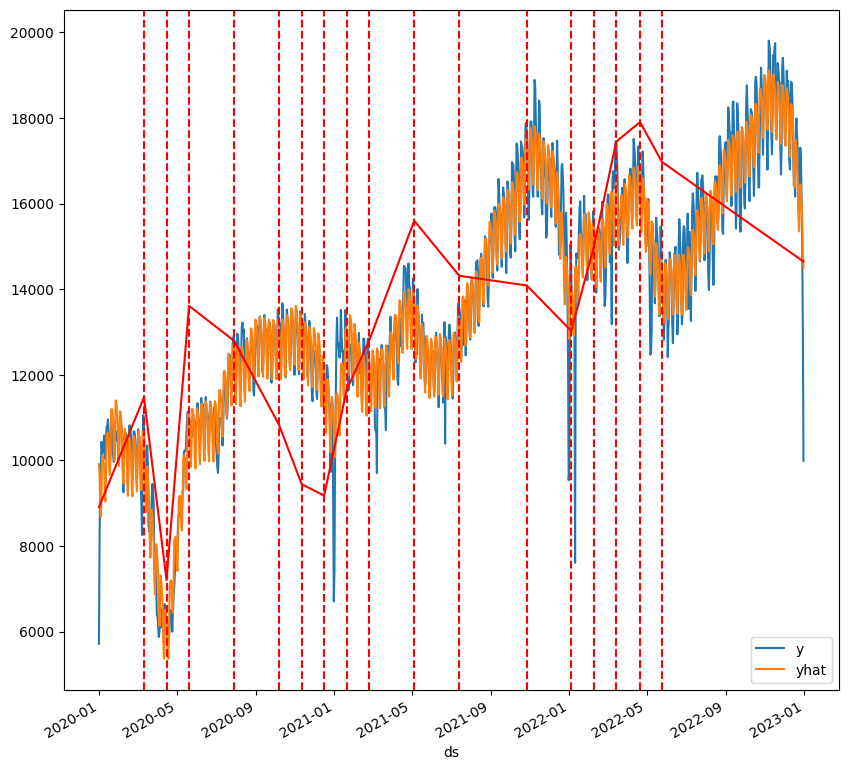

In [20]:
model = Prophet(changepoint_prior_scale=0.6)

model.fit(data)

cv_results = cross_validation(
    model, 
    initial=initial, 
    horizon=horizon, 
    period=period,
    parallel="processes"
)
plot(model)
'MAPE: ', np.average(performance_metrics(cv_results).mape.values)

14:26:44 - cmdstanpy - INFO - Chain [1] start processing
14:26:45 - cmdstanpy - INFO - Chain [1] done processing


('MAPE: ', 0.08130191188065534)

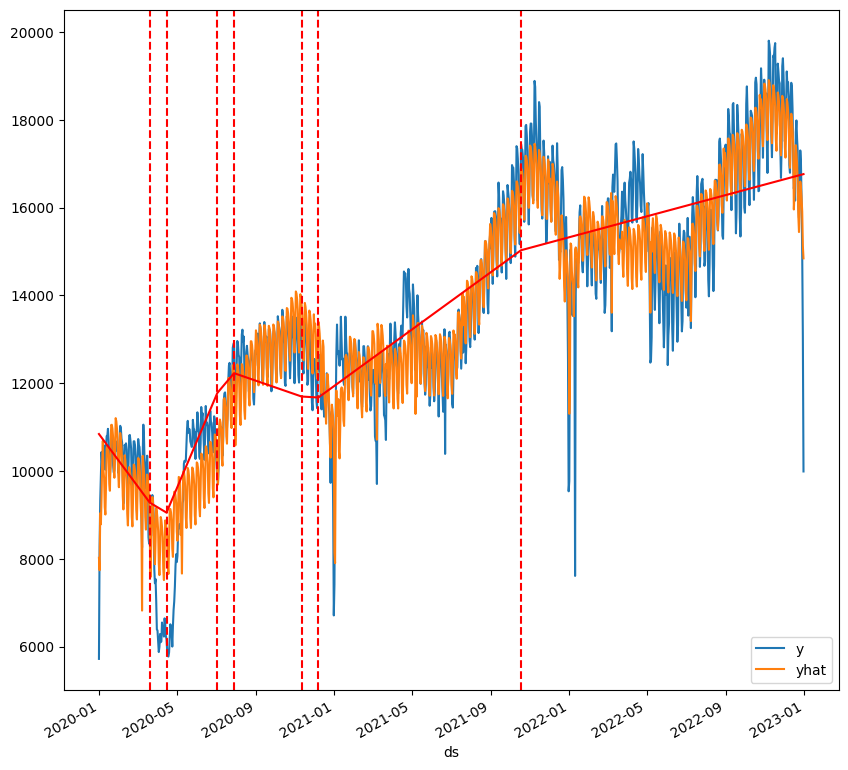

In [21]:
model = Prophet(holidays=df_holidays, changepoint_range=0.6)

model.fit(data)
cv_results = cross_validation(
    model, 
    initial=initial, 
    horizon=horizon, 
    period=period,
    parallel="processes"
)
plot(model)
'MAPE: ', np.average(performance_metrics(cv_results).mape.values)

Поиск лучших параметров

In [22]:
param_grid = {
    'changepoint_prior_scale': np.logspace(0, 10, 5, base = 500**(1/10))/1000,
    'seasonality_prior_scale': np.logspace(0, 10, 5, base = 100**(1/10))/10,
    'holidays_prior_scale': np.logspace(0, 10, 5, base = 100**(1/10))/10,
    'seasonality_mode': ['additive', 'multiplicative'],
}

all_params = [dict(zip(param_grid.keys(), values)) for values in itertools.product(*param_grid.values())]

In [23]:
def train(params): 
    model = Prophet(changepoint_range=0.8,
                    holidays = df_holidays,
                    **params).add_regressor('ramadan').add_regressor('covid')
    
    model.fit(data)
    cv_results = cross_validation(
        model, 
        initial=initial, 
        horizon=horizon, 
        period=period,
        parallel="processes"
    )

    return np.average(performance_metrics(cv_results).mape.values)


In [24]:
mapes = []

print(len(all_params))

start_time = time()
for params in all_params:
    mapes.append(train(params))

print('Time elapsed:', time() - start_time)
best_params = all_params[np.argmin(mapes)]
'MAPE:', min(mapes) 

250


14:26:50 - cmdstanpy - INFO - Chain [1] start processing
14:26:50 - cmdstanpy - INFO - Chain [1] done processing
14:26:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:26:51 - cmdstanpy - INFO - Chain [1] start processing
14:26:55 - cmdstanpy - INFO - Chain [1] done processing
14:26:59 - cmdstanpy - INFO - Chain [1] start processing
14:26:59 - cmdstanpy - INFO - Chain [1] done processing
14:26:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:26:59 - cmdstanpy - INFO - Chain [1] start processing
14:27:05 - cmdstanpy - INFO - Chain [1] done processing
14:27:09 - cmdstanpy - INFO - Chain [1] start processing
14:27:09 - cmdstanpy - INFO - Chain [1] done processing
14:27:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Time elapsed: 1588.2497601509094


('MAPE:', 0.061349701315711255)

In [25]:
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 3.162277660168381, 'holidays_prior_scale': 10.000000000000007, 'seasonality_mode': 'additive'}


Запуск с лучшими параметрами

14:53:19 - cmdstanpy - INFO - Chain [1] start processing
14:53:19 - cmdstanpy - INFO - Chain [1] done processing
14:53:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:53:19 - cmdstanpy - INFO - Chain [1] start processing
14:53:24 - cmdstanpy - INFO - Chain [1] done processing


('MAPE: ', 0.061043130593005444)

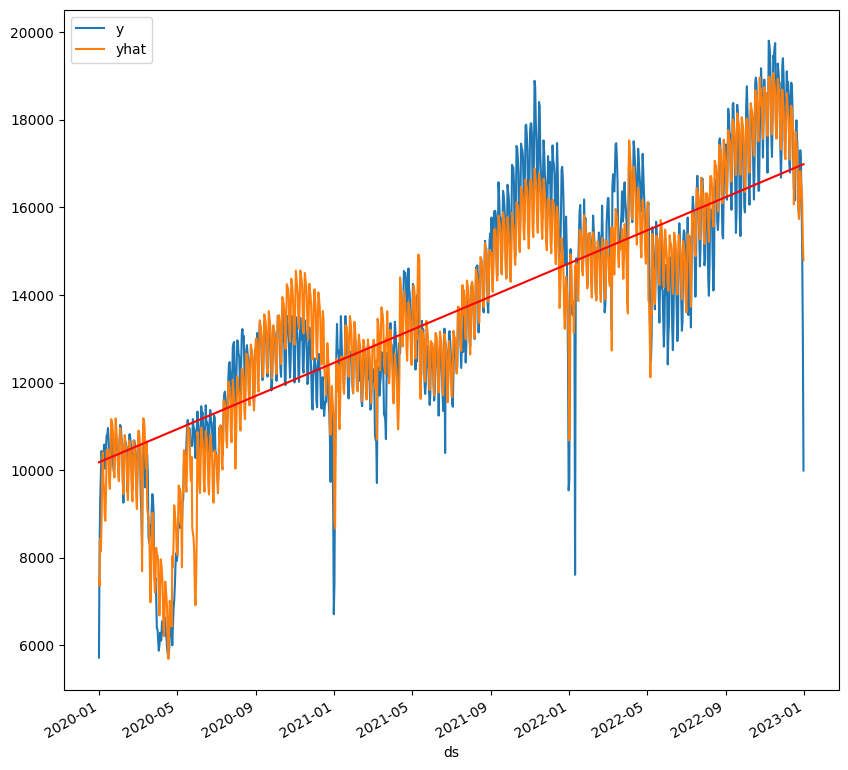

In [26]:
model = Prophet(holidays=df_holidays, changepoint_range=0.6, 
                **best_params).add_regressor('ramadan').add_regressor('covid')
model.add_seasonality(name='monthly_season', period=30.5, fourier_order=7)

model.fit(data)
cv_results = cross_validation(
    model, 
    initial=initial, 
    horizon=horizon, 
    period=period,
    parallel="processes"
)
plot(model)
'MAPE: ', np.average(performance_metrics(cv_results).mape.values)

Поиск инсайтов

c:\repos\Kolesa-python-exam\venv\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\repos\Kolesa-python-exam\venv\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\repos\Kolesa-python-exam\venv\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain th

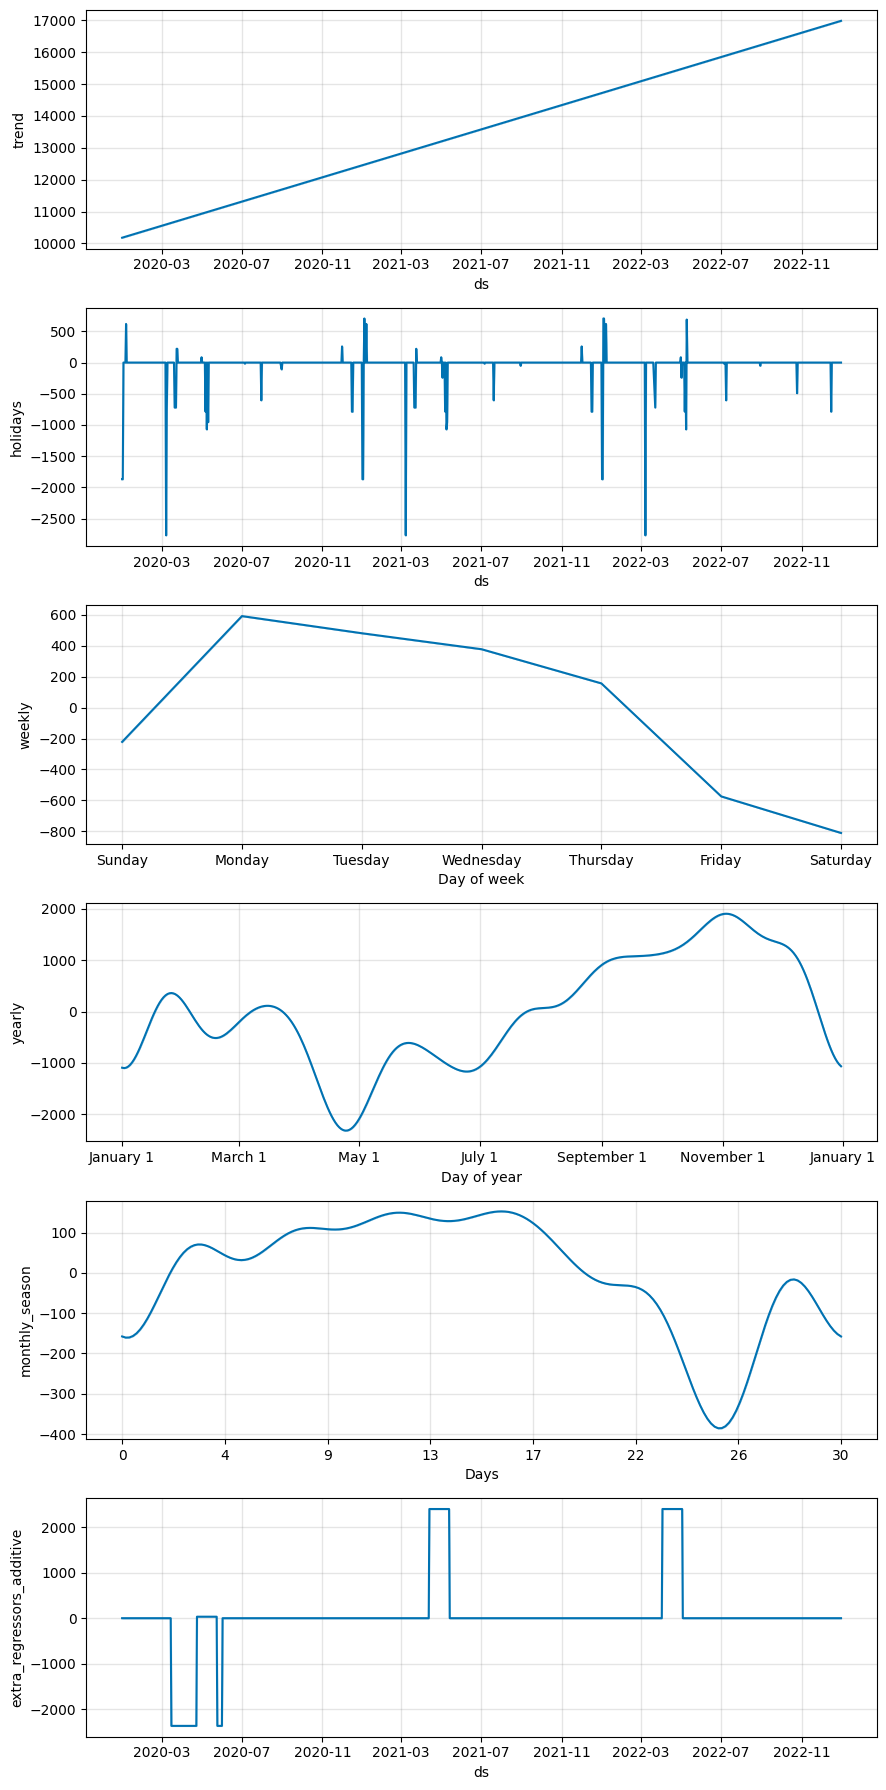

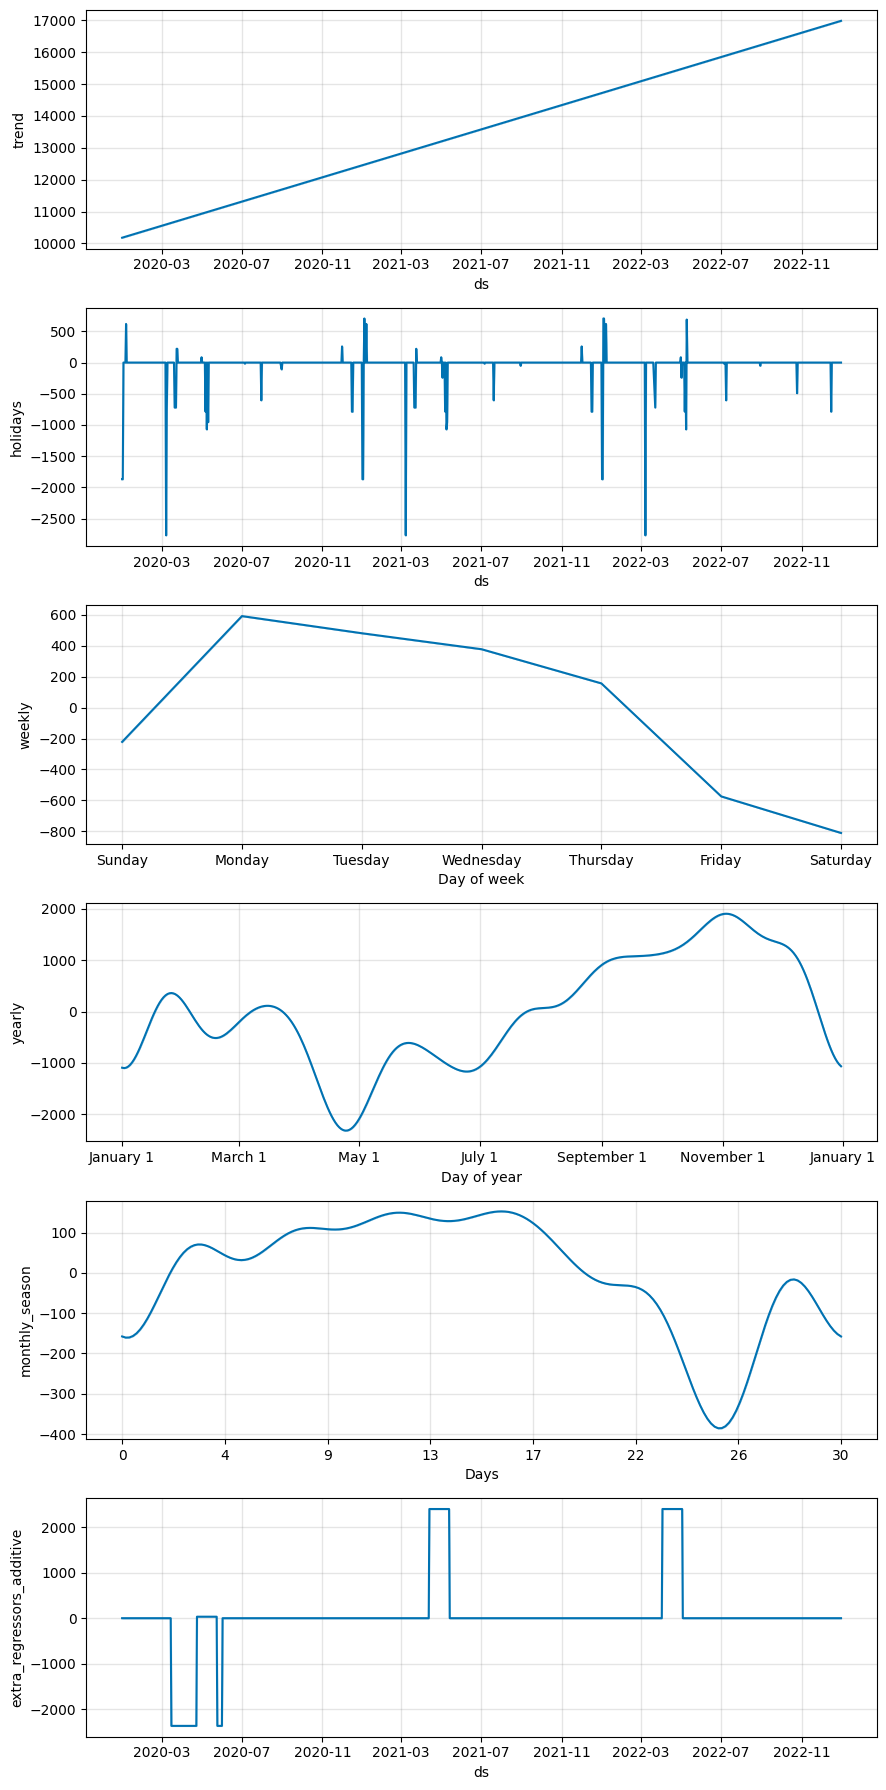

In [27]:
model.plot_components(model.predict(data))

Накатывание модели

In [28]:
train = data[:-int(data.shape[0]/20)]
test = data[-int(data.shape[0]/20):]
test = test.drop('ds',axis=1)
test = test.reset_index()

In [29]:
model = Prophet(holidays=df_holidays, changepoint_range=0.8, 
                **best_params).add_regressor('ramadan').add_regressor('covid')
model.add_seasonality(name='monthly_season', period=30.5, fourier_order=7)

In [30]:
model.fit(train)

14:53:36 - cmdstanpy - INFO - Chain [1] start processing
14:53:36 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
predict_data = model.make_future_dataframe(test.shape[0], include_history=False)

In [32]:
predict_data = predict_data.merge(test, on='ds', how='left')

In [33]:
predict_data = model.predict(predict_data)

In [34]:
predict_data

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Capital Day,Capital Day_lower,Capital Day_upper,Constitution Day of the Republic of Kazakhstan,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-11-08,16533.456272,17574.663151,19962.778971,16533.456272,16533.456272,0.0,0.0,0.0,0.0,...,459.244110,459.244110,459.244110,1851.046641,1851.046641,1851.046641,0.0,0.0,0.0,18752.998221
1,2022-11-09,16539.556851,17556.515451,20011.258499,16539.556851,16539.556851,0.0,0.0,0.0,0.0,...,369.053304,369.053304,369.053304,1825.200468,1825.200468,1825.200468,0.0,0.0,0.0,18745.669395
2,2022-11-10,16545.657430,17341.987748,19729.553266,16545.657430,16545.657430,0.0,0.0,0.0,0.0,...,160.612767,160.612767,160.612767,1796.415043,1796.415043,1796.415043,0.0,0.0,0.0,18530.966476
3,2022-11-11,16551.758009,16660.656604,18927.935021,16551.758009,16551.758009,0.0,0.0,0.0,0.0,...,-548.739965,-548.739965,-548.739965,1765.143513,1765.143513,1765.143513,0.0,0.0,0.0,17776.993050
4,2022-11-12,16557.858588,16358.876062,18805.818910,16557.858588,16557.858588,0.0,0.0,0.0,0.0,...,-773.604518,-773.604518,-773.604518,1731.873929,1731.873929,1731.873929,0.0,0.0,0.0,17553.929706
5,2022-11-13,16563.959167,16915.158061,19268.261296,16563.959167,16563.959167,0.0,0.0,0.0,0.0,...,-228.930294,-228.930294,-228.930294,1697.116972,1697.116972,1697.116972,0.0,0.0,0.0,18131.544592
6,2022-11-14,16570.059746,17737.607192,20070.787248,16570.059746,16570.059746,0.0,0.0,0.0,0.0,...,562.364597,562.364597,562.364597,1661.392690,1661.392690,1661.392690,0.0,0.0,0.0,18915.191222
7,2022-11-15,16576.160325,17581.130764,19920.403854,16576.160325,16576.160325,0.0,0.0,0.0,0.0,...,459.244110,459.244110,459.244110,1625.216569,1625.216569,1625.216569,0.0,0.0,0.0,18759.965803
8,2022-11-16,16582.260905,17469.646672,19774.287390,16582.260905,16582.260911,0.0,0.0,0.0,0.0,...,369.053304,369.053304,369.053304,1589.085308,1589.085308,1589.085308,0.0,0.0,0.0,18635.292746
9,2022-11-17,16588.361484,17243.574620,19595.872818,16588.361483,16588.361509,0.0,0.0,0.0,0.0,...,160.612767,160.612767,160.612767,1553.462661,1553.462661,1553.462661,0.0,0.0,0.0,18431.531595


In [35]:
mean_absolute_percentage_error(test['y'], predict_data['yhat'])

0.04038115973350517

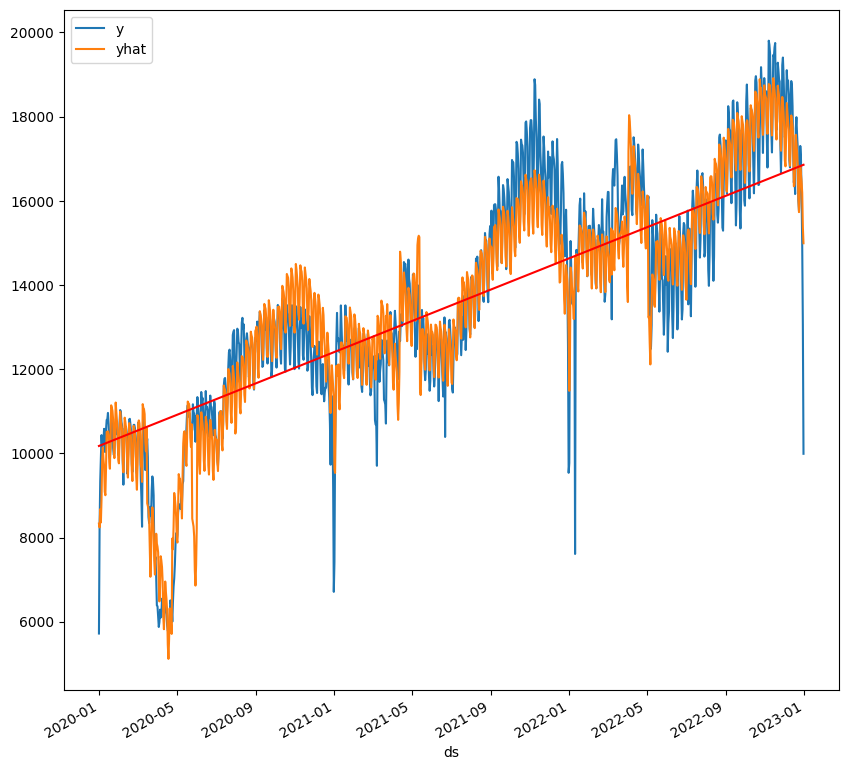

In [36]:
plot(model)

<Axes: >

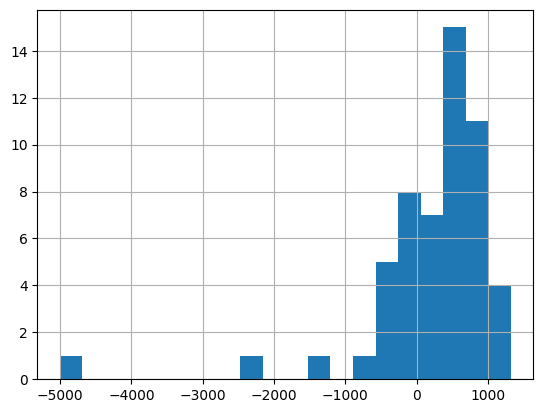

In [37]:
(test['y'] - predict_data['yhat']).hist(bins=20)

In [38]:
np.mean(test['y'] - predict_data['yhat'])

216.43119324010357

Постр процессинг

In [76]:
res = test.merge(predict_data[['ds', 'yhat']], on='ds', how='left')

In [77]:
res['residuals'] = res['yhat'] - res['y']

In [78]:
print('max: ',res['residuals'].idxmax())
print('min: ',res['residuals'].idxmin())

max:  53
min:  9


In [79]:
res.iloc[53]

ds            2022-12-31 00:00:00
y                          9991.0
is_ramadan                  False
ramadan                         0
is_covid                    False
covid                           0
yhat                 14993.077591
residuals             5002.077591
Name: 53, dtype: object

In [80]:
res.iloc[9]

ds            2022-11-17 00:00:00
y                         19750.0
is_ramadan                  False
ramadan                         0
is_covid                    False
covid                           0
yhat                 18431.531595
residuals            -1318.468405
Name: 9, dtype: object

In [81]:
res = res.drop(53)
res = res.drop(9)

In [83]:
res = res[res['residuals'] > -1000]

In [84]:
mean_absolute_percentage_error(res['y'], res['yhat'])

0.0294584459647062

<Axes: >

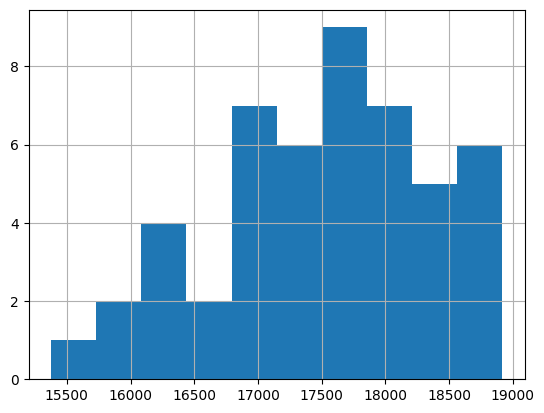

In [85]:
res['yhat'].hist()

In [86]:
model = Prophet(holidays=df_holidays, changepoint_range=0.8,
                **best_params).add_regressor('ramadan').add_regressor('covid')

In [87]:
model.fit(data)

15:04:46 - cmdstanpy - INFO - Chain [1] start processing
15:04:46 - cmdstanpy - INFO - Chain [1] done processing
15:04:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:04:46 - cmdstanpy - INFO - Chain [1] start processing
15:04:50 - cmdstanpy - INFO - Chain [1] done processing


In [88]:
ds = model.make_future_dataframe(365, include_history=True)

In [89]:
ds['ramadan'] = ds['ds'].apply(is_ramadan)
ds['covid'] = ds['ds'].apply(is_covid)

In [90]:
model.predict(ds)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Capital Day,Capital Day_lower,Capital Day_upper,Constitution Day of the Republic of Kazakhstan,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,10184.047880,6459.268985,8600.965482,10184.047880,10184.047880,0.0,0.0,0.0,0.0,...,374.047028,374.047028,374.047028,-1051.883000,-1051.883000,-1051.883000,0.0,0.0,0.0,7537.547376
1,2020-01-02,10190.262291,6117.666477,8340.901436,10190.262291,10190.262291,0.0,0.0,0.0,0.0,...,152.398485,152.398485,152.398485,-1068.086351,-1068.086351,-1068.086351,0.0,0.0,0.0,7305.909893
2,2020-01-03,10196.476702,7493.683857,9617.484240,10196.476702,10196.476702,0.0,0.0,0.0,0.0,...,-574.928522,-574.928522,-574.928522,-1070.662915,-1070.662915,-1070.662915,0.0,0.0,0.0,8550.885265
3,2020-01-04,10202.691113,7240.898270,9448.312919,10202.691113,10202.691113,0.0,0.0,0.0,0.0,...,-810.229248,-810.229248,-810.229248,-1059.751604,-1059.751604,-1059.751604,0.0,0.0,0.0,8332.710261
4,2020-01-05,10208.905524,7845.947372,10037.012830,10208.905524,10208.905524,0.0,0.0,0.0,0.0,...,-219.852733,-219.852733,-219.852733,-1035.722532,-1035.722532,-1035.722532,0.0,0.0,0.0,8953.330259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2023-12-27,19232.230423,17849.973104,19903.299025,19232.230236,19232.230578,0.0,0.0,0.0,0.0,...,374.047028,374.047028,374.047028,-777.447302,-777.447302,-777.447302,0.0,0.0,0.0,18828.830149
1455,2023-12-28,19238.444834,17504.997806,19573.362237,19238.444646,19238.444990,0.0,0.0,0.0,0.0,...,152.398485,152.398485,152.398485,-856.009450,-856.009450,-856.009450,0.0,0.0,0.0,18534.833869
1456,2023-12-29,19244.659245,16681.585117,18756.360753,19244.659057,19244.659401,0.0,0.0,0.0,0.0,...,-574.928522,-574.928522,-574.928522,-923.568332,-923.568332,-923.568332,0.0,0.0,0.0,17746.162390
1457,2023-12-30,19250.873656,16314.500029,18536.483204,19250.873468,19250.873812,0.0,0.0,0.0,0.0,...,-810.229248,-810.229248,-810.229248,-979.194687,-979.194687,-979.194687,0.0,0.0,0.0,17461.449722


ИТОГ

In [91]:
res = model.predict(ds)

c:\repos\Kolesa-python-exam\venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\repos\Kolesa-python-exam\venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


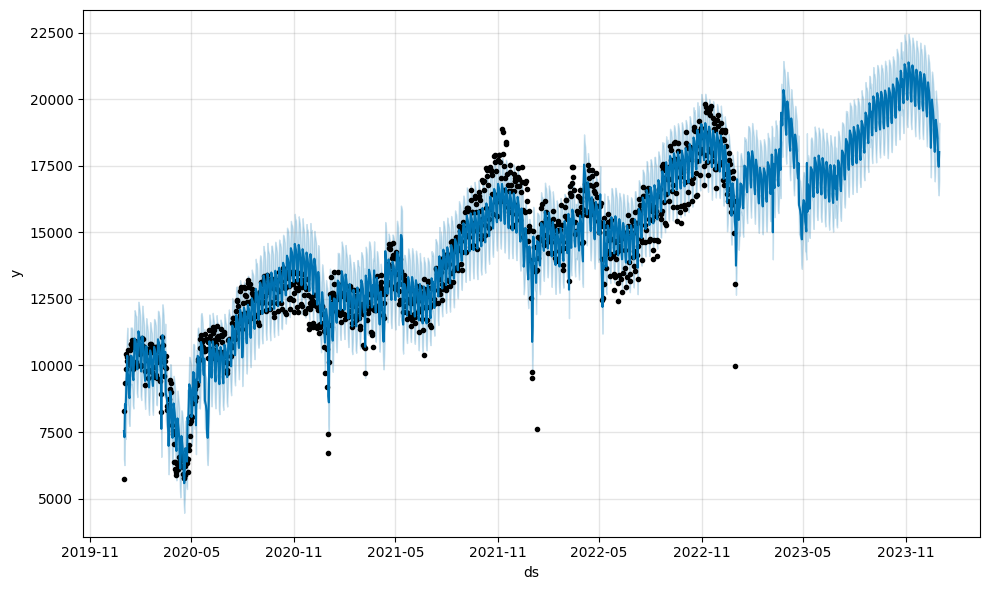

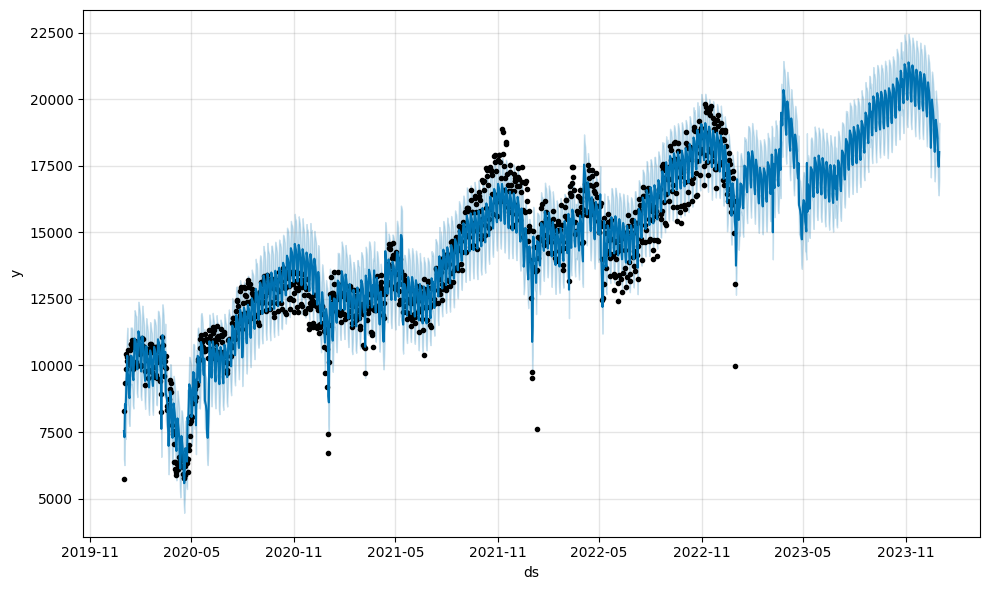

In [92]:
model.plot(res)